In this notebook, we'll try analyzing Sylas's data of beads in networks using methods described in this [Cho et al 2020 PRL paper](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005).

With DDM, we take a movie and generate the DDM matrix, $D(q,\Delta t)$ (the generation of this DDM matrix should already have been done before going through this code). This can be fit to the function:
$D(q,\Delta t) = A(q)(1 - f(q,\Delta t)) + B(q)$. 
The function $f(q,\Delta t)$ is called the intermediate scattering function (ISF). And we usually assume it has the form: $f(q,\Delta t) = \mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)}$ where $\alpha (q)$ is the stretching exponent and $\tau (q)$ is the characteristic decay time.

What we have usually tried is to take $D(q,\Delta t)$ and, for each wave vector $q$, fit it to find the parameters $A, B, \tau, \text{ and } \alpha$.

What we do now (using the methods of [Cho et al](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005)) is get the parameters $A$ and $B$ from the images themselves. Then we can get the ISF: $f(q,\Delta t) = 1 - \frac{D(q,\Delta t) - B(q)}{A(q)}.$ 

We also add a new paramter to the ISF: the non-ergodicity parameter, $C$. So now we have that the ISF is equal to: $f(q,\Delta t) = (1-C(q))\mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)} + C(q)$. If $C$ is zero, then this ISF is just $\mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)}$, as we had before. And that's the expected case for ergodic dynamics. But if the system is non-ergodic, then we expect a non-zero $C$, somewhere between 0 and 1. 

Note that in this code, we refer to $D(q, \Delta t)$ as 'ravs'. That is because getting $D(q, \Delta t)$ invovles finding the <b>r</b>adial <b>av</b>erages of a matrix.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font_plt = {'family': 'serif','color':  'darkred','weight': 'normal','size': 8,}
font_plt_ax = {'family': 'serif','color':  'black','weight': 'normal', 'size': 8,}

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import os
import csv
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
from scipy.optimize import leastsq
import pickle #for saving data
from importlib import reload

Y:\Pawan K\CODE\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
Y:\Pawan K\CODE\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
Y:\Pawan K\CODE\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
reload(ddm) #reload of ddm necessary if changes have been made

<module 'ddm_clean' from 'Y:\\Pawan K\\CODE\\DDM\\ddm_clean.py'>

## Movie number and ROI specified below

In [3]:
#######################################################################################
#Specify where the data is stored and the image data filename. Must be in tiff format
#######################################################################################


#######################################################################################
# UNCOMMENT OUT ONE OF THESE CONDITIONS. 
# The naming scheme, e.g., ActinXL-1, ActinXL-2, ..., will be used later in following
# code that gathers together all analyses. 
#######################################################################################

#We'll call these "Entangled-1" and "Entangled-2"
#condition = "Beads_Glycerol"
#condition = "20_1_21_Entangled"

#We'll call these "ActinXL-1" and "ActinXL-2"
#condition = "19_12_17_XLActin"
#condition = "20_1_18_XLActin"

#We'll call these "MicrotubulesXL-1" and "MicrotubulesXL-2"
#condition = "19_12_3_XLMicrotubules"
#condition = "20_1_16_XLMicrotubules"

#We'll call these "CoXL-1" and "CoXL-2"
#condition = "20_1_14_CoXL"
#condition = "20_1_17_CoXL"

#We'll call these "BothXL-1" and "BothXL-2"
#condition = "20_1_16_BothXL"
#condition = "20_1_18_BothXL"


########################
# Select Movie Number  #
#movie_num = 2
########################

########### Select ROI here ###############
#ROI = 0  # <---- select ROI (0,1,2, or 3)
###########################################

#data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\"+condition+"\\DDM\\_%i\\" % movie_num
#data_file = "_%i_MMStack_Pos0.ome.tif" % movie_num
#video= 1
#ROI= 0Y:\\Pawan K\\2021_DATA\\Rheology\\March_30_2021_Fos25_Linear_2mgml\\5

#data_dir = "Y:\\Pawan K\\2021_DATA\\Rheology\\March_23_Dextran_40%\\8\\"
#data_file = "1.tif" 
#data_file = "%s_%s_256x256_FFTDIFFS_dts_ravs.p" %(video, ROI)

## Below, we load in the images. If this step was already done and you can read in the pickle file containing the necessary data, don't bother rerunning this.

Y:\Pawan K\CODE\DDM\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


<IPython.core.display.Javascript object>


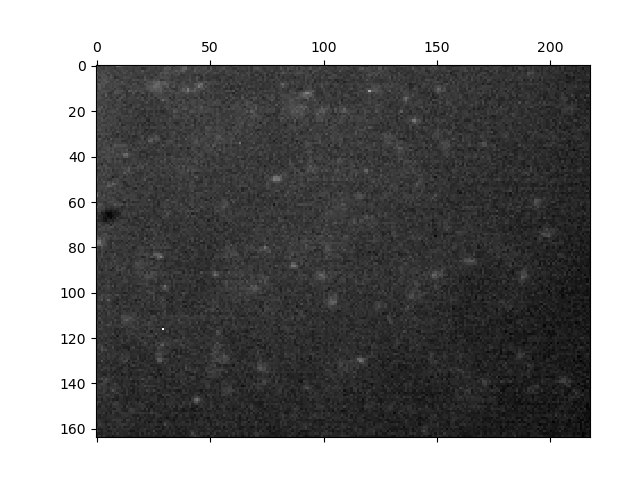

In [4]:
data_dir = "Y:\\Pawan K\\2021_DATA\\Rheology\\2021_04_26_40%Dextran+LabeledFos25_40mmParallel\\After_shear_videos\\10fps_5000frames_2\\"
data_file = "2.tif" 


#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

### Open up the previosly generated DDM matrix data

In [5]:
#######################################################################################
#  Specify where the DDM matrix data is stored
#######################################################################################
#data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\"+condition+"\\DDM\\analysis\\"
#data_file = "_%i_MMSta\ck_Pos0.ome_%i_256x256_FFTDIFFS_dts_ravs.p" % (movie_num, ROI)
video= 2
ROI= 0

data_dir = "Y:\\Pawan K\\2021_DATA\\Rheology\\2021_04_26_40%Dextran+LabeledFos25_40mmParallel\\After_shear_videos\\10fps_5000frames_2\\"
data_file = "%s_%s_164x164_FFTDIFFS_dts_ravs.p" %(video, ROI)

f = open(data_dir + data_file,'rb')
p_data = pickle.load(f)
f.close()
print("The 'keys' contained in this pickle'd dictionary are: ", p_data.keys())

The 'keys' contained in this pickle'd dictionary are:  dict_keys(['dts', 'ffts', 'ravs'])


In [6]:
#copy over that data stored in the dictionary
ravs = p_data['ravs']
dts = p_data['dts']

In [7]:
##########################################################################
# Specify the frame rate (fps) and pixel size
##########################################################################

fps = 10.0 #The frame rate the video data was recorded at. 
times = dts/fps #Create the list of delay times in units of seconds
pixel_size = 0.1 #pixel size in microns
numPixels = 164 #number pof pixels in ROI
q = np.arange(0,numPixels/2)*2*np.pi*(1./(numPixels*pixel_size)) #Convert the spatial frequencies to wave vectors

<IPython.core.display.Javascript object>


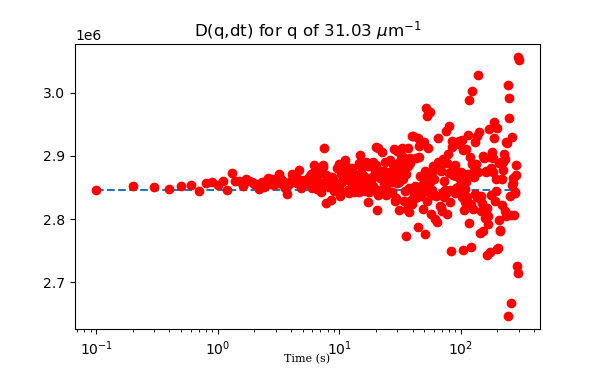

Horizontal line at 2846734.0


In [8]:
# Here, we'll show the image structure function for a particular q-value. 

qv= -1# <-- this is the last q-value. useful for getting estimate of background
fig = plt.figure(figsize=(6,6./1.618))
plt.semilogx(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.xlabel('Time (s)', fontdict=font_plt_ax, labelpad=-3);
plt.title("D(q,dt) for q of %.2f $\mu$m$^{-1}$" % q[qv]);
plt.hlines(ravs[0,qv], times[0], times[-1], linestyles='dashed')
print("Horizontal line at %.1f" % ravs[0,qv])

At this step, we could try fitting $D(q, \Delta t)$ to the model described at the very beginning to determine $A$, $B$, $\tau$ and $\alpha$. If you want to do that, you'll find the code at the end of this notebook. But that step isn't necessary.

## New method for getting A and B



In [10]:
#Data file to store avg abs(fft)^2 which we need for getting A and B
#First, let us check whether this file already exists. If it does,
#we don't have to calculate it again
data_file = "%i_%i_164x164_rav_imageffts_for_AB.p" % (video, ROI)

data_file_exists = os.path.isfile(data_dir + data_file)
if data_file_exists:
    print("Data file already exists.")
else:
    print("Data file does NOT exist.")

Data file does NOT exist.


In [11]:
#This uses the variable 'ROI' which you should have set at the beginning (as 0, 1, 2, or 3)

if not data_file_exists:
    
    #these are the initial and final x and y coordinates for 
    #  the different ROIs  Here the x and the y are switched
    xi=[0,0]
    xf=[164,164]
    yi=[27,0]
    yf=[191,0]
    
    ''' xi=[118,118]
    xf=[374,374]
    yi=[72, 328]
    yf=[328,584]'''
    
    '''xi=[0, 256, 0, 256]
    xf=[256, 512, 256, 512]
    yi=[0, 0, 256, 256]
    yf=[256, 256, 512, 512]'''
    
    
    #Get the dimensions of the ROI'd image
    nframes, ndx, ndy = im[:,xi[ROI]:xf[ROI],yi[ROI]:yf[ROI]].shape
    print("Our image has %i frames and each frame is %i x %i pixels" % (nframes, ndx,ndy))

    #get the average abs(fft)^2 for each frame
    av_fftsq_of_each_frame = np.zeros_like(im[0,xi[ROI]:xf[ROI],yi[ROI]:yf[ROI]]*1.0) #initialize array
    for i in range(0, nframes):
        #looping over all frames in the movie
        fft_of_image = np.fft.fft2(im[i,xi[ROI]:xf[ROI],yi[ROI]:yf[ROI]]*1.0)
        sqr_of_fft = np.fft.fftshift(fft_of_image*np.conj(fft_of_image))
        av_fftsq_of_each_frame = av_fftsq_of_each_frame + abs(sqr_of_fft)
    av_fftsq_of_each_frame = av_fftsq_of_each_frame/(1.0*nframes*ndx*ndy)
    
    #get radially average
    rad_av_av_fftsq = ddm.radialAvFFTs_v2(av_fftsq_of_each_frame.reshape(1,ndx,ndy))

    data_file = "%i_%i_256x256_rav_imageffts_for_AB.p" % (video, ROI)
    f = open(data_dir + data_file,'wb')
    pickle.dump({'rad_av_av_fftsq': rad_av_av_fftsq}, f)
    f.close()
    
else:
    f = open(data_dir + data_file,'rb')
    p_data = pickle.load(f)
    f.close()
    rad_av_av_fftsq = p_data['rad_av_av_fftsq']

Our image has 5000 frames and each frame is 164 x 164 pixels


In [12]:

#print("Our image has %i frames and each frame is %i x %i pixels" % (nframes, ndx,ndy))

In [13]:
#im.shape?
#plt.matshow(im[1], cmap=matplotlib.cm.gray)

<IPython.core.display.Javascript object>


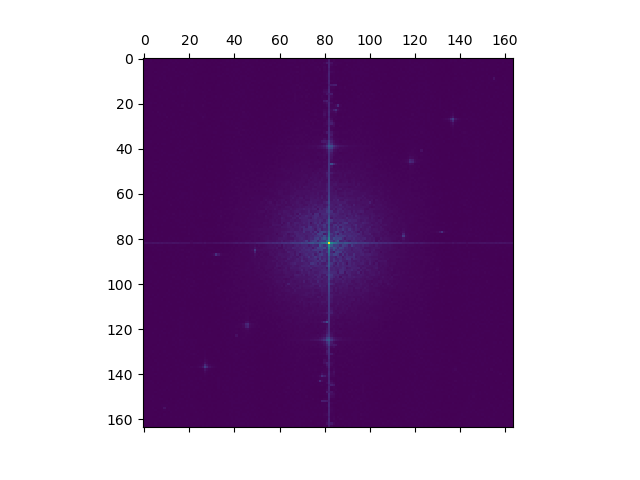

In [14]:
if not data_file_exists:    
    #here we just show the fourier transformed image, if we had to calculate it
    plt.figure()
    plt.matshow(np.log(av_fftsq_of_each_frame),fignum=0)
else:
    print("The 2D array of the avg ft(I)^2 not saved, just the radial average.")

<IPython.core.display.Javascript object>


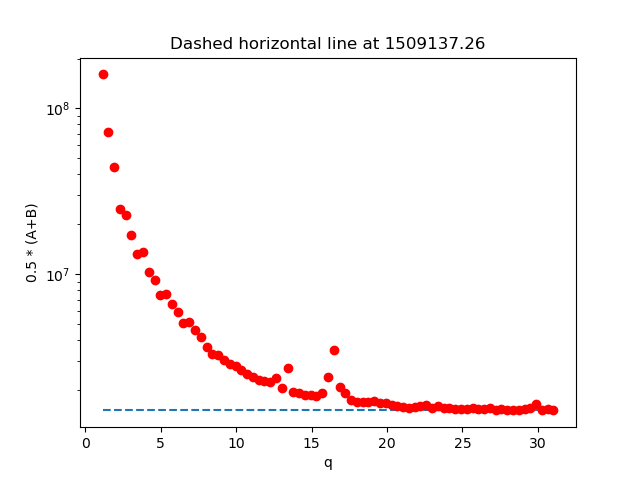

Text(0.5, 1.0, 'Dashed horizontal line at 1509137.26')

In [15]:
plt.figure()
plt.semilogy(q[3:], rad_av_av_fftsq[0,3:],'ro')
plt.xlabel("q")
plt.ylabel("0.5 * (A+B)")
plt.hlines(rad_av_av_fftsq[0,-1], q[3], q[-1], linestyles='dashed')
plt.title("Dashed horizontal line at %.2f" % rad_av_av_fftsq[0,-1])

Based off of the DDM data, I'd say the background is ~ 40 (in many cases, depends on video). 
Based off the above plot, seems like it (1/2)(A+B) is plateauing at high q to around ??. So B is around twice that. 

In [16]:
############################################################
#You can play around with this 'background' parameter
############################################################
background =  ravs[0,qv]
new_amplitude = (2*rad_av_av_fftsq[0]) - background

print("Background used %i" %ravs[0,qv])

Background used 2846734


<IPython.core.display.Javascript object>


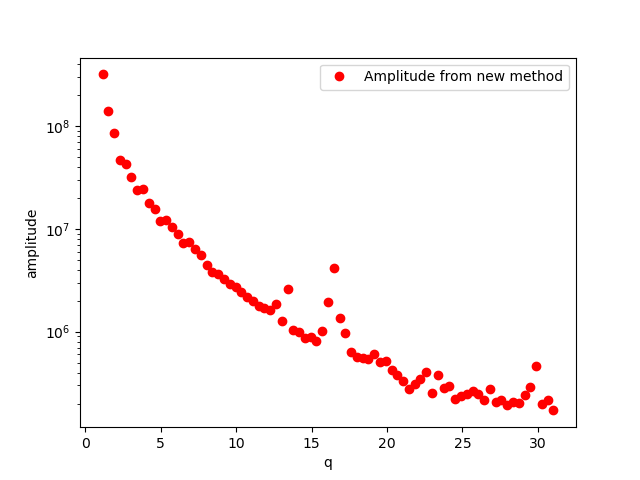

'amp' not defined


In [17]:
plt.figure()
plt.semilogy(q[3:], new_amplitude[3:], 'ro', label='Amplitude from new method')
try: plt.plot(q[3:], amp[2:], 'mo', label='Amplitude from fitting method')
except: print("'amp' not defined")
plt.xlabel("q")
plt.ylabel("amplitude")
plt.legend(loc=0)

Based on our new value for amplitude, let's find the intermediate scattering function

In [18]:
#Just double checking sizes of arrays:
print("size of ravs array (the ddm matrix or image struct func): %i by %i" % ravs.shape)
print("size of new amplitudes: %i" % new_amplitude.shape)

size of ravs array (the ddm matrix or image struct func): 400 by 82
size of new amplitudes: 82


In [19]:
#Initialize arrays to store the ISF (intermediate scattering function)
isf = np.zeros_like(ravs) #decay time
msd = np.zeros_like(ravs)

for i in range(1,ravs.shape[1]):
    isf[:,i] = 1 - ((ravs[:,i] - background) / new_amplitude[i])
    msd[:,i] = (-4.0 / ((q[i])**2.0))*np.log(1 - ((ravs[:,i] - background) / new_amplitude[i]))

<ipython-input-19-89747c1fa71b>:7: RuntimeWarning: invalid value encountered in log
  msd[:,i] = (-4.0 / ((q[i])**2.0))*np.log(1 - ((ravs[:,i] - background) / new_amplitude[i]))


<IPython.core.display.Javascript object>


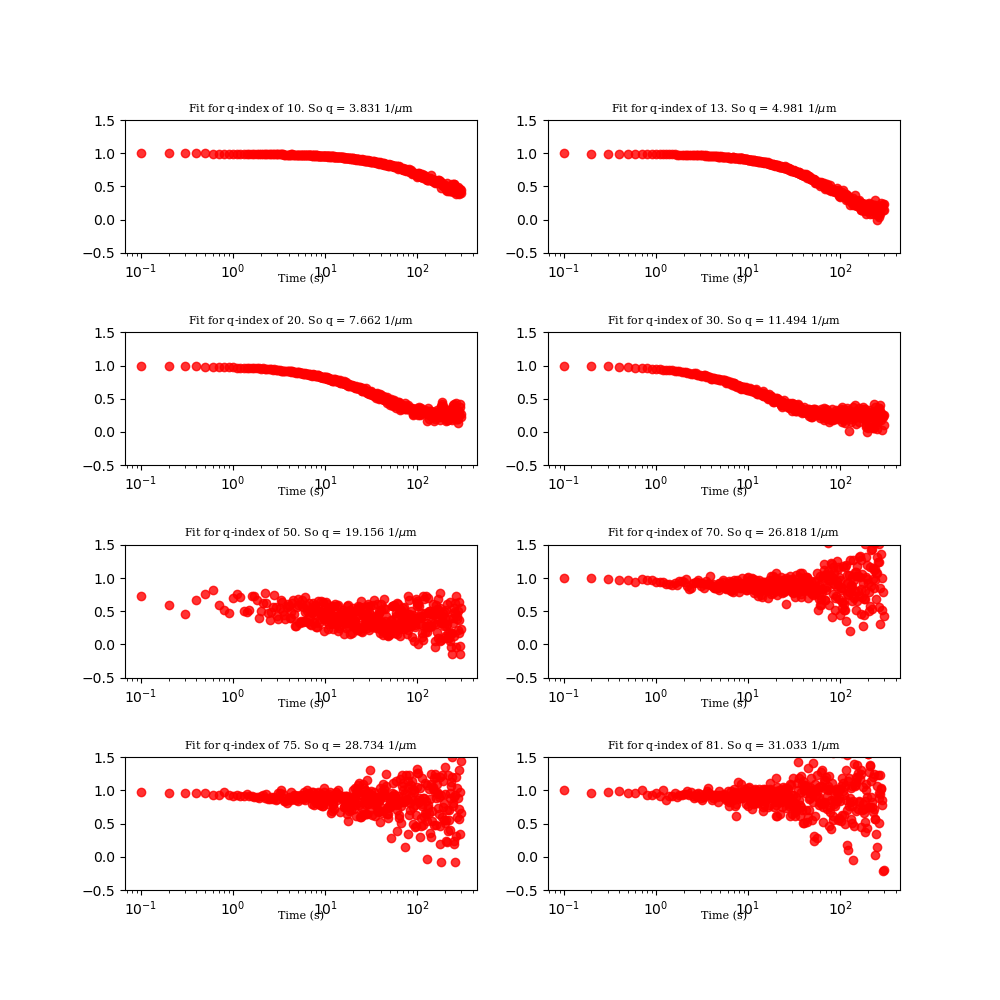

In [20]:
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([10,13,20,30,50,70,75,81]):

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,isf[:,q_index],'ro',alpha=0.8)
    matplotlib.pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax, labelpad=-5)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    
    ax.set_ylim(-0.5,1.5)
    
plt.savefig(data_dir+"\\"+"_ROI_"+str(ROI)+"_ISF.png",dpi=150)

### Defining the fitting function

The fitting function, `isf_fitting`, is described below. After running through this cell (and the next 3 or 4), you'll need to come back to this point and re-run this function after you settle on a stretching exponent to use. You'll come back to the first uncommented-out line: <br>
`STRETCHING_EXP = 0.6` <br>
and set the value (which is the stretching exponent, $\alpha (q)$) to the correct value. 

<IPython.core.display.Javascript object>


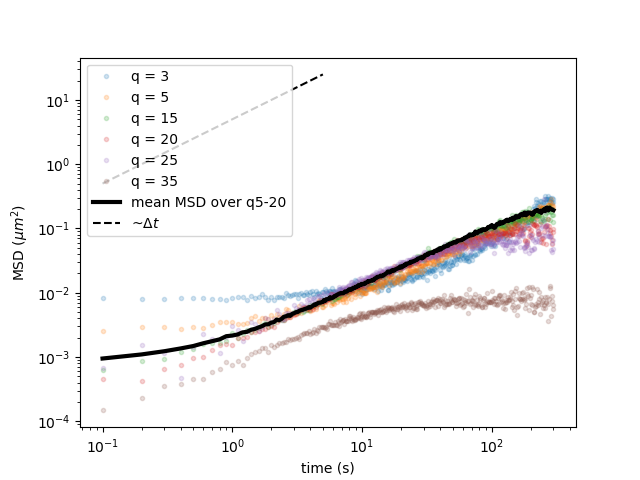

In [21]:
plt.figure()
#col=["b",'g','r','c','m','y']
q_loop=[3,5,15,20,25,35]
#col=np.linspace(0.1,1,len(q_loop))
for i,qi in enumerate(q_loop):
    plt.loglog(times,msd[:,qi], ".", label="q = %i"%q_loop[i], alpha=0.2)

msd_ave=np.zeros(len(times))
for i in range(len(msd[:,0])):
    qmin=5
    qmax=20
    msd_ave[i]=np.nanmean(msd[i,qmin:qmax])
    
plt.plot(times[:1000],msd_ave[:1000],'-k', lw=3., label="mean MSD over q%i-%i"%(qmin,qmax))
plt.plot(times[:50], 5*times[:50],'--k', label="~$\Delta t$")
plt.xlabel("time (s)")
plt.ylabel("MSD ($\mu$$m^{2}$)")
plt.legend() 
#np.savetxt(data_dir+data_file[:-18]+"MSD_q%i-%i.csv"%(qmin,qmax), msd_ave, delimiter=',')
#np.savetxt(data_dir+data_file[:-18]+"times.csv", times, delimiter=',')
np.savetxt(data_dir+data_file [:-18]+ "MSD_times_q%i-%i.csv"%(qmin,qmax),np.c_[msd_ave, times],delimiter = ',',header = "MSD,times")

In [37]:
##################################################################################################
# Stretching exponent.
# This number must be between 0 and 1. 
# And it will probably be around 0.6.
# When you specify the value, don't go beyond hundredths place.
# Set this to the AVERAGE VALUE you found when this parameter was allowed to vary.
##################################################################################################
STRETCHING_EXP = 0.83 # <----- THIS NUMBER NEEDS TO CHANGE AFTER GOING THROUGH NEXT COUPLE STEPS!

##################################################################################################
# Fix stretching exponent... it may help to fix
# Set this to true or false. 
# 
# BUT WE'LL SET THIS PARAMETER'S VALUE (TRUE or FALSE) ELSEWHERE
# So leave this commented out for now
#  
##################################################################################################
#FIX_STRETCHING_EXP = False #False will allow stretching exponent to vary. True will hold constant

def errorfunc_for_scipy_leastsq_fit(params, data, times):
    theory = ddm.dTheoryNonErgISF(times, params[0],params[1],params[2])
    return data-theory

def isf_fitting(data, times):
    '''
    This function does the ISF fitting. 

    We'll just use one round. Using Levenberg-Marquardt method with the mpfit module. 
    '''
    
    #Our parameters are: c (non-ergodicity param), tau, stretching epxonent
    pars = np.zeros(3)*1.0
    minp = np.zeros_like(pars)
    maxp = np.zeros_like(pars)
    lmin = np.array([True, True, True])
    lmax = np.array([True, True, True])
    fix = np.array([False, False, False])
    
    #come up with limits:
    minp[0] = 0.0 #minimum non-erg parameter
    maxp[0] = 1.0 #maximum non-erg parameter
    minp[1] = 0.01 #minimum decay time
    maxp[1] = 3000.0  #maximum decay time
    minp[2] = 0.1 #minimum stretching exponent
    maxp[2] = 2.0 #maximum stretching exponent
    
    #initial guesses 
    pars[0] = 1.0 #non-ergodicity parameter
    pars[1] = 50.0 #decay time
    ############################################################################
    # Below (pars[2]) is the stretching exponent. 
    # After letting it vary, set to average value and
    # fix it at that.
    #
    # YOU MUST CHANGE THIS TO AVERAGE VALUE OVER REASONALBE RANGE OF Q
    ###########################################################################
    pars[2] = STRETCHING_EXP #stretching exponent. 
    
    fix[2] = FIX_STRETCHING_EXP   #True or False -- set above
    
    # First step, use the Scipy Least Squares function to find best parameters
    #   We will then use those parameters as initial guess in the Levenberg-Marquardt method
    fitparams_lstsq_temp = leastsq(errorfunc_for_scipy_leastsq_fit, pars, args=(data,times))
    fitparams_isf_lstsq = fitparams_lstsq_temp[0]
    theory_isf_lstsq = ddm.dTheoryNonErgISF(times, fitparams_isf_lstsq[0], fitparams_isf_lstsq[1], fitparams_isf_lstsq[2])
    
    #sometimes the leastsq's function will return parameters outside the limits we impose
    #  so check for that and correct if necessary
    for i in [1,2]:
        if not fix[i]:
            if fitparams_isf_lstsq[i] > maxp[i]:
                pars[i] = 0.99*maxp[i]
            elif fitparams_isf_lstsq[i] < minp[i]:
                pars[i] = 1.01*minp[i]
            else:
                pars[i] = fitparams_isf_lstsq[i]
        if fitparams_isf_lstsq[0]>0:
            if fitparams_isf_lstsq[0]<1.0:
                pars[0] = fitparams_isf_lstsq[0]


    fitparams_isf, theory_isf, errCode, chi2 = ddm.newFit_ISF(data,times,pars,minp,maxp,lmin,lmax,fix,
                                                              logfit=False,quiet=True,factor=1)
    
    return fitparams_isf, theory_isf, chi2, fitparams_isf_lstsq, theory_isf_lstsq


In the next cell, we define the time lag that we end the fits at. We do this because the data for long time lags gets noisier. It also gets more noisy for high q at long times than low q at long times. So we make the last time we fit to a function of q. 

In [38]:
last_times = np.linspace(700,2,num=len(q),dtype=np.int)

In this cell, we'll inspect some (8) of the fits to the ISF. Hopefully they look okay. Make a note if any of them look off. 

<IPython.core.display.Javascript object>


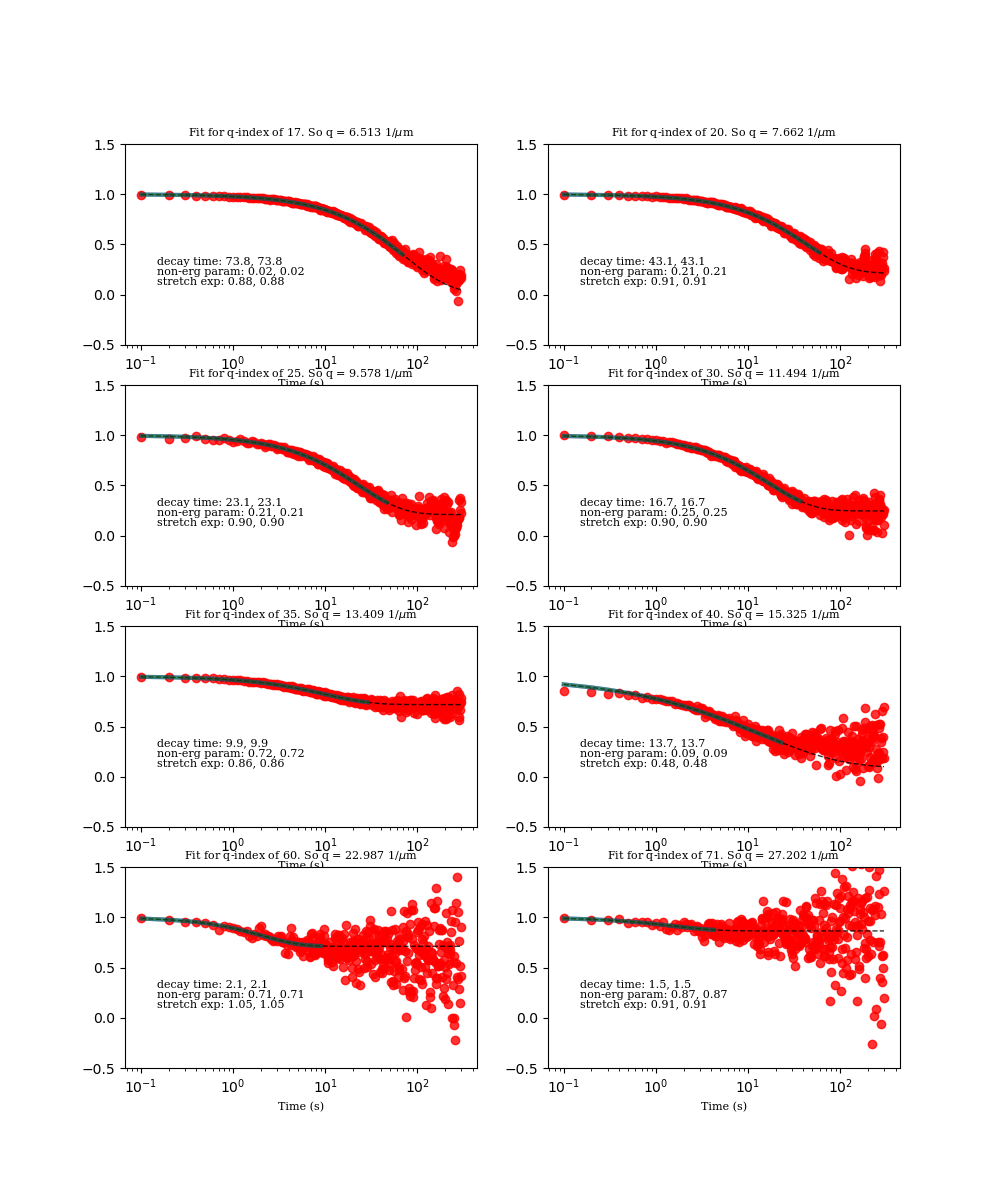

Saved as Y:\Pawan K\2021_DATA\Rheology\2021_04_26_40%Dextran+LabeledFos25_40mmParallel\After_shear_videos\10fps_5000frames_2\2_0_256x256_rav_imageffts_for_AB_ISF.png


In [51]:
#########################################################################
# We don't have to fit all time lags. The long time lags may be noisy.
#########################################################################
# not implemented anymore: last_time = -350 # ONLY FIT UP TO THIS FINAL TIME POINT

plt.figure(figsize=(10,12)) #Create figure of size 10x12

#########################################################################
# In making these plots, we'll not fix the stretching exponent.
# But feel free to change this.
#########################################################################
FIX_STRETCHING_EXP = False


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([17,20,25,30,35,40,60,71]):
    last_times = np.linspace(340,2,num=len(q),dtype=np.int)
    last_time = last_times[q_index]
    #last_time = 285
    
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,q_index],times[:last_time])
    full_time_theory = ddm.dTheoryNonErgISF(times, *fp_isf)

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times[:],isf[:,q_index],'ro',alpha=0.8)
    ax.plot(times[:last_time], theory_isf, '-b',lw=3,alpha=0.5) #BLUE LINE: Leven-Marq fitting method
    ax.plot(times, full_time_theory, '--k',lw=1,alpha=0.8) #BLUE LINE: Leven-Marq fitting method
    ax.plot(times[:last_time], theory_isf_lstsq,'-g',lw=3,alpha=0.5) #GREEN LINE: scipy.optimize's leastsquares function
    
    ax.text(0.15,0.3, "decay time: %.1f, %.1f" % (fp_isf[1], fp_isf_lstsq[1]), fontdict=font_plt_ax)
    ax.text(0.15,0.2, "non-erg param: %.2f, %.2f" % (fp_isf[0], fp_isf_lstsq[0]), fontdict=font_plt_ax)
    ax.text(0.15,0.1, "stretch exp: %.2f, %.2f" % (fp_isf[2], fp_isf_lstsq[2]), fontdict=font_plt_ax)
    
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    ax.set_ylim(-0.5,1.5)
    
plt.savefig(data_dir+data_file[:-2]+"_ISF.png",dpi=150)
print("Saved as %s" % data_dir+data_file[:-2]+"_ISF.png")

Hopefully, the above fits to the normalize image structure function look okay. If not, you can try adjusting the `last_times` parameter. Sometimes, removing more of the last few time points from the data we fit to helps since the data associated with very long time lags tends to be noisier. 

Below, we do the fits for each wave vector (each q). We do this twice. One with fixing the stretching exponent and one time with letting it vary. When you see the results after the following code block, you'll choose the value for this stretching exponent and insert that value back into the block of code where the function `isf_fitting` was defined above. 

In [40]:
#Now, we'll do that fit for *all* q-values

FIX_STRETCHING_EXP = True
#Initialize arrays to store the fit paramters
tau_v2 = np.zeros_like(ravs[0,:]) #decay time
c = np.zeros_like(tau_v2) #this is the non-ergodicity parameter
alph_v2 = np.zeros_like(tau_v2) #alpha (stretching exponent)
for i in range(1,len(tau_v2)-1):
    #print(i)
    last_time = last_times[i]
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,i],times[:last_time])
    c[i] = fp_isf[0]
    tau_v2[i] = fp_isf[1]
    alph_v2[i] = fp_isf[2]

    
FIX_STRETCHING_EXP = False
#Initialize arrays to store the fit paramters -- THIS TIME FIXING ALPHA
tau_v2_varyalpha = np.zeros_like(ravs[0,:]) #decay time
c_varyalpha = np.zeros_like(tau_v2) #this is the non-ergodicity parameter
alph_v2_varyalpha = np.zeros_like(tau_v2) #alpha (stretching exponent)
for i in range(1,len(tau_v2_varyalpha)-1):
    last_time = last_times[i]
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,i],times[:last_time])
    c_varyalpha[i] = fp_isf[0]
    tau_v2_varyalpha[i] = fp_isf[1]
    alph_v2_varyalpha[i] = fp_isf[2]

C:\Users\pkhanal\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


print(q.shape)
print(tau_v2.shape)

<IPython.core.display.Javascript object>


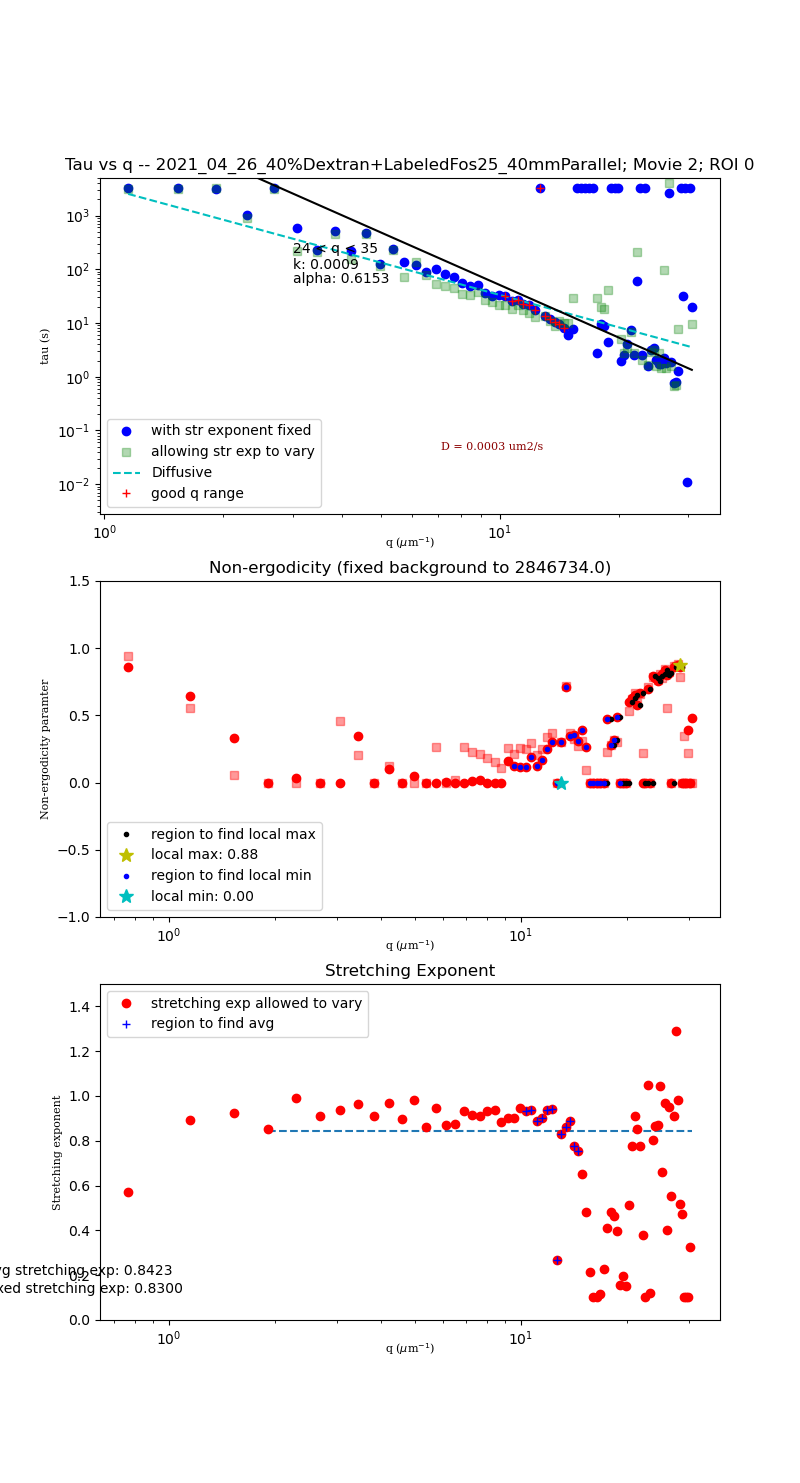

'slope' of tau vs q is -3.25


<ipython-input-46-6de8c89a4952>:73: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-10,5000)


Saved to Y:\Pawan K\2021_DATA\Rheology\2021_04_26_40%Dextran+LabeledFos25_40mmParallel\After_shear_videos\10fps_5000frames_2\2_0_256x256_rav_imageffts_for_AB_tauvsq_nonergparam.png


In [46]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,3*8/1.618)); ax = fig.gca();
ax = plt.subplot(3,1,1)

plt.title("Tau vs q -- " + data_dir.split('\\')[-4] + "; Movie " + str(video) + "; ROI " + str(ROI))
qs=q[3:-1]
new_taus=ddm.newt(tau_v2[3:-1],alph_v2[3:-1])
new_taus_varyalpha=ddm.newt(tau_v2_varyalpha[3:-1],alph_v2_varyalpha[3:-1])
#ax.loglog(qs, tau_v2[2:-1],'g.',alpha=0.2) 
ax.loglog(qs, new_taus,'bo', label='with str exponent fixed')
ax.loglog(qs, new_taus_varyalpha,'gs',alpha=0.3, label='allowing str exp to vary')

#############################################################################
# Pick the range of q-value that seem to fit best (usually ~25ish to ~42ish)
#############################################################################
minq=24
maxq=35

### this is the fit for diffusion coefficient  #######
diffusion_coeff = .0003 # you can change this to get a rough estimate of the diffusion coef
power = 2.0 
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**power), '--c', label="Diffusive")
plt.legend()

ax.text(0.55,0.2,'D = %.4f um2/s' % diffusion_coeff,
       fontdict=font_plt,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

## does it fit some other power?
#adiffusion_coeff = .022
#power2 = 3
#ax.plot(q[3:-1], (1./adiffusion_coeff) * 1./(q[3:-1]**power2), '--k')


qmin=qs[minq]
qmax=qs[maxq]

############################################
########STRETCHING EXPONENT FIXED###########
############################################
b = np.where((qs>=qmin)&(qs<=qmax))
ax.plot(qs[b[0]],new_taus[b[0]],'r+',label='good q range')
a = np.polyfit(np.log(qs[b[0]]),np.log(new_taus[b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])
alpha = 2./(-1*slope)
Dif = (1.0/coef1)**alpha
tau_fit = coef1*(qs**(-2.0/alpha))
ax.plot(qs, tau_fit, '-k')
print("'slope' of tau vs q is %.2f" % slope)

############################################
########STRETCHING EXPONENT VARIED###########
############################################

'''b = np.where((qs>=qmin)&(qs<=qmax))
ax.plot(qs[b[0]],new_taus_varyalpha[b[0]],'r+',label='good q range')
a = np.polyfit(np.log(qs[b[0]]),np.log(new_taus_varyalpha[b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])
alpha = 2./(-1*slope)
Dif = (1.0/coef1)**alpha
tau_fit = coef1*(qs**(-2.0/alpha))
ax.plot(qs, tau_fit, '-k')
print("'slope' of tau vs q is %.2f" % slope)'''


ax.text(3,55, "alpha: %.4f" % alpha)
ax.text(3,100, "k: %.4f" % Dif)

ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.text(3,200, "%i < q < %i" % (minq, maxq))
ax.set_ylim(-10,5000)
ax.legend(loc=0)


#Plot the non-erg parameter versus the wave vector
ax = plt.subplot(3,1,2)
plt.title("Non-ergodicity (fixed background to %.1f)" % background)
ax.semilogx(q[2:-1], c[2:-1], 'ro')
cs_fix = c[2:-1]
cs_vary = c_varyalpha[2:-1]
ax.semilogx(q[2:-1], c_varyalpha[2:-1], 'rs', alpha=0.4)
c_range = np.where((qs>=q[45])&(qs<=q[75]))
ax.semilogx(qs[c_range], c[2:-1][c_range], 'k.',label='region to find local max')
c_local_max = c[2:-1][c_range].max()
where_local_max = np.argmax(c[2:-1][c_range])
ax.semilogx(qs[c_range][where_local_max], c_local_max, '*', c='y', ms=10, label='local max: %.2f' % c_local_max)
c_range = np.where((qs>=q[25])&(qs<=q[50]))
ax.semilogx(qs[c_range], c[3:-1][c_range], 'b.',label='region to find local min')
c_local_min = c[2:-1][c_range].min()
where_local_min = np.argmin(c[2:-1][c_range])
ax.semilogx(qs[c_range][where_local_min], c_local_min, '*', c='c', ms=10, label='local min: %.2f' % c_local_min)
ax.set_ylim(-1,1.5)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Non-ergodicity paramter", fontdict=font_plt_ax)
ax.legend(loc=0)

#Plot the stretching exponent versus the wave vector
ax = plt.subplot(3,1,3)
plt.title("Stretching Exponent")
ax.semilogx(q[2:-1], alph_v2_varyalpha[2:-1], 'ro',label='stretching exp allowed to vary')
stretch_vary = alph_v2_varyalpha[2:-1]
stretch_fix = alph_v2[2:-1]
#ax.semilogx(q[2:-1], alph_v2[2:-1], 'rs')
ax.plot(qs[b[0]],alph_v2_varyalpha[3:-1][b[0]],'b+',label='region to find avg')
ax.hlines(alph_v2_varyalpha[2:-1][b[0]].mean(), qs[2],qs[-1], linestyles='dashed')
ax.text(0.3,0.2,"Avg stretching exp: %.4f" % alph_v2_varyalpha[2:-1][b[0]].mean())
ax.text(0.3,0.12,"Fixed stretching exp: %.4f" % alph_v2[2])
ax.set_ylim(0,1.5)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Stretching exponent", fontdict=font_plt_ax)
ax.legend(loc=0)

#Save this figure at a PNG file.
plt.savefig(data_dir+data_file[:-2]+"_tauvsq_nonergparam.png",dpi=150)
print("Saved to %s" % data_dir+data_file[:-2]+"_tauvsq_nonergparam.png")

## IMPORTANT!

After looking at the plots above, figure out a good value for the stretching exponent (what we call 'alpha' in the code). It should be the average stretching exponent over a range of q values. The range of q values in use is indicated with the red or blue crosses on the plot of the decay time vs q and stretching exponent vs q. If that range seems inappropriate, change the `minq` and `maxq` paratmers.

Once you've found that, go back to the fitting function -- the `isf_fitting` function -- was defined, and find the first line of that block of code: <br />
`STRETCHING_EXP = 0.6`. <br />
(Or, it might not say '0.6' but some other number.) <br />
Change that value from whatever is to the new value (probably something between 0.5 and 0.8 though it could range anywhere between 0 and 1) and you only need to go to the hundredths place -- no need to go to further decimal places.

In [49]:
fitting_parameters = {} #initialize empty dictionary
fitting_parameters['last_times'] = last_times
fitting_parameters['qs'] = q
fitting_parameters['q_used'] = [minq,maxq]
fitting_parameters['c'] = c
fitting_parameters['c_varyalpha'] = c_varyalpha
fitting_parameters['c_localmax'] = c_local_max
fitting_parameters['c_localmin'] = c_local_min
fitting_parameters['tau'] = tau_v2
fitting_parameters['tau_varyalpha'] = tau_v2_varyalpha
fitting_parameters['stretching_exponent'] = alph_v2_varyalpha
fitting_parameters['stretching_exponent_fixed'] = alph_v2[2]
fitting_parameters['k'] = Dif
fitting_parameters['alpha'] = alpha
fitting_parameters['fps'] = fps
fitting_parameters['pixel_size'] = pixel_size
fitting_parameters['data_directory'] = data_dir
fitting_parameters['Movie'] = video
fitting_parameters['ROI'] = ROI
fitting_parameters['ISF'] = isf
fitting_parameters['times'] = times
fitting_parameters['background'] = background
fitting_parameters['ravs'] = ravs

data_file_p = data_file[:-18]+"NormalizedISFFitting_ExpoFit.p"
f = open(data_dir+ data_file_p,'wb')
pickle.dump(fitting_parameters, f, protocol=2)
f.close()

#Varied Strecthing Exponent?

qindex=[10,15,20,25,30,35,40]
ten = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[0]],fitting_parameters['tau_varyalpha'][qindex[0]],
                           fitting_parameters['stretching_exponent'][qindex[0]])
fifteen = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[1]],fitting_parameters['tau_varyalpha'][qindex[1]],
                           fitting_parameters['stretching_exponent'][qindex[1]])
twenty = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[2]],fitting_parameters['tau_varyalpha'][qindex[2]],
                           fitting_parameters['stretching_exponent'][qindex[2]])
twentyfive = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[3]],fitting_parameters['tau_varyalpha'][qindex[3]],
                           fitting_parameters['stretching_exponent'][qindex[3]])
thirty = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[4]],fitting_parameters['tau_varyalpha'][qindex[4]],
                           fitting_parameters['stretching_exponent'][qindex[4]])
thirtyfive = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[5]],fitting_parameters['tau_varyalpha'][qindex[5]],
                           fitting_parameters['stretching_exponent'][qindex[5]])
forty = ddm.dTheoryNonErgISF(times,fitting_parameters['c_varyalpha'][qindex[6]],fitting_parameters['tau_varyalpha'][qindex[6]],
                           fitting_parameters['stretching_exponent'][qindex[6]])
#Fixed Strecthing Exponent?

tenfix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[0]],fitting_parameters['tau'][qindex[0]],
                           fitting_parameters['stretching_exponent_fixed'])
fifteenfix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[1]],fitting_parameters['tau'][qindex[1]],
                           fitting_parameters['stretching_exponent_fixed'])
twentyfix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[2]],fitting_parameters['tau'][qindex[2]],
                           fitting_parameters['stretching_exponent_fixed'])
twentyfivefix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[3]],fitting_parameters['tau'][qindex[3]],
                           fitting_parameters['stretching_exponent_fixed'])
thirtyfix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[4]],fitting_parameters['tau'][qindex[4]],
                           fitting_parameters['stretching_exponent_fixed'])
thirtyfivefix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[5]],fitting_parameters['tau'][qindex[5]],
                           fitting_parameters['stretching_exponent_fixed'])
fortyfix = ddm.dTheoryNonErgISF(times,fitting_parameters['c'][qindex[6]],fitting_parameters['tau'][qindex[6]],
                           fitting_parameters['stretching_exponent_fixed'])

data_file_p = data_file[:-18]+"_EXPO_ISFs.csv"
f = open(data_dir +data_file_p,'w')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow(["time","q10","q10fit_vary","q10fit_fix","q15","q15fit_vary","q15fit_fix",
                     "q20","q20fit_vary","q20fit_fix",
                     "q25","q25fit_vary","q25fit_fix","q30","q30fit_vary","q30fit_fix"])
for i in range(len(fitting_parameters['ISF'][:,0])):
    filewriter.writerow([times[i], fitting_parameters['ISF'][i,qindex[0]], ten[i],tenfix[i],
                         fitting_parameters['ISF'][i,qindex[1]], fifteen[i],fifteenfix[i],
                         fitting_parameters['ISF'][i,qindex[2]], twenty[i],twentyfix[i],
                         fitting_parameters['ISF'][i,qindex[3]], twentyfive[i],twentyfivefix[i],
                         fitting_parameters['ISF'][i,qindex[4]], thirty[i],thirtyfix[i],
                        fitting_parameters['ISF'][i,qindex[5]], thirtyfive[i],thirtyfivefix[i],
                        fitting_parameters['ISF'][i,qindex[6]], forty[i],fortyfix[i]])
f.close()

data_file_t = data_file[:-18]+"_EXPO_tau_v_q.csv"
f = open(data_dir +data_file_t,'w')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow(['qs','new_tau_fixalpha', 'new_tau_varyalpha','stretching_fixed','stretching_vary','c_fixed','c_vary'])
for i in range(len(qs)):
    filewriter.writerow([qs[i], new_taus[i], new_taus_varyalpha[i], stretch_fix[i],stretch_vary[i],cs_fix[i],cs_vary[i]])
f.close()

data_file_p = "_%i_MMStack_Pos0.ome_%i_256x256_NormalizedISFFitting.p" % (video, ROI)
f = open(data_dir + data_file_p,'wb')
pickle.dump(fitting_parameters, f)
f.close()

In [50]:
#write some data to more readable file
csv_data_file = "_%i_ROI_%i_256x256_parameters.csv" % (video, ROI)
f = open(data_dir + csv_data_file,'w')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow([data_dir])
filewriter.writerow(['Movie','ROI','k','alpha','avg stretching exp','non-erq at q=2.457'])
filewriter.writerow([str(video), str(ROI), "%.4f" % Dif, "%.4f" % alpha, "%.4f" % alph_v2[2:-1][b[0]].mean(), 
                    "%.4f" % c[35]])
f.close()

print("Saving to a csv file that you can open with Excel: \n")
print("  k: %.4f \n  alpha: %.4f \n  stretch. exp.: %.4f \n  c[35]: %.4f" % (Dif, alpha, alph_v2[2:-1][b[0]].mean(), c[35]))

Saving to a csv file that you can open with Excel: 

  k: 0.0009 
  alpha: 0.6153 
  stretch. exp.: 0.8300 
  c[35]: 0.7107


## After analyzing all four ROIs of a movie, combine data.

In [97]:
## If you want to combine these files from some other data directory, you can edit data_dir. Otherwise don't.
print("Current 'data_dir' is %s" % data_dir)

Current 'data_dir' is Y:\Pawan K\2021_DATA\Rheology\2021_04_26_40%Dextran+LabeledFos25_40mmParallel\1fps\1\


In [98]:
#changing data_dir
#data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\20_1_14_CoXL\\analysis\\"

In [99]:
csv_files = glob.glob(data_dir + "*_%i_ROI*.csv" % video)

csv_all_data_file = "_%i_all_256x256_parameters.csv" % video
f_all = open(data_dir + csv_all_data_file,'w')
filewriter = csv.writer(f_all, delimiter=',')
f_all_header_not_written_yet = True

for i,filename in enumerate(csv_files):
    if not "_all_" in filename:
        f = open(filename,'r')
        filereader = csv.reader(f, delimiter=',')
        for j,row in enumerate(filereader):
            if f_all_header_not_written_yet:
                filewriter.writerow(row)
            else:
                if j>1:
                    filewriter.writerow(row)
        f_all_header_not_written_yet = False
        f.close()
f_all.close()

## Getting a bit experimental

In [149]:
#Using method from Cho et al 2020 supplemental info
dlin = np.zeros_like(ravs)
bg = background
for i in range(ravs.shape[1]): #loop over all q
    non_erg = c[i]
    dlin_part1 = 1 - ((ravs[:,i]-bg)/(new_amplitude[i]*(1-non_erg)))
    dlin[:,i] = np.log(-1*np.log(dlin_part1))
log_dt = np.log(times)

<ipython-input-149-3ba64fb61b07>:7: RuntimeWarning: invalid value encountered in log
  dlin[:,i] = np.log(-1*np.log(dlin_part1))


<IPython.core.display.Javascript object>


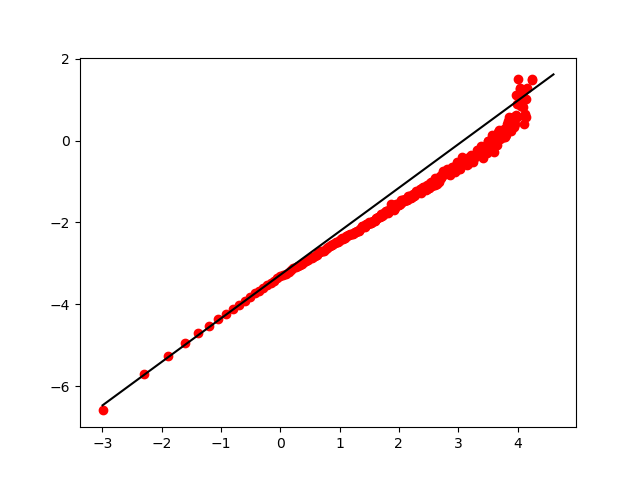

In [150]:
q_index = 2
end_time = 20
fig = plt.figure()
plt.plot(log_dt, dlin[:,q_index],'ro')
linear_fit = np.polyfit(log_dt[0:end_time], dlin[0:end_time,q_index], 1)
plt.plot(log_dt, np.polyval(linear_fit, log_dt), '-k')

In [51]:
print("the y-intercept is %.4f and the slope is %.4f" % (linear_fit[1], linear_fit[0]))

the y-intercept is -1.4918 and the slope is 0.6593


In [61]:
#from this linear fit we can get tau and the stretching exponent
stretch_exp = linear_fit[0]
new_meth_tau = np.exp(-1*linear_fit[1]/linear_fit[0])
print("From this we find a stretching exponent of: %.4f" % stretch_exp)
print("And we find a tau of: %.4f" % new_meth_tau)

From this we find a stretching exponent of: 0.9098
And we find a tau of: 5.3740


In [62]:
new_meth_taus = np.zeros_like(tau)*1.0
stretch_exp = np.zeros_like(new_meth_taus)*1.0
for i in range(1,len(new_taus)):
    linear_fit = np.polyfit(log_dt[0:end_time], dlin[0:end_time,i], 1)
    #print linear_fit
    stretch_exp[i] = linear_fit[0]
    new_meth_taus[i] = np.exp(-1*linear_fit[1]/linear_fit[0])


<IPython.core.display.Javascript object>


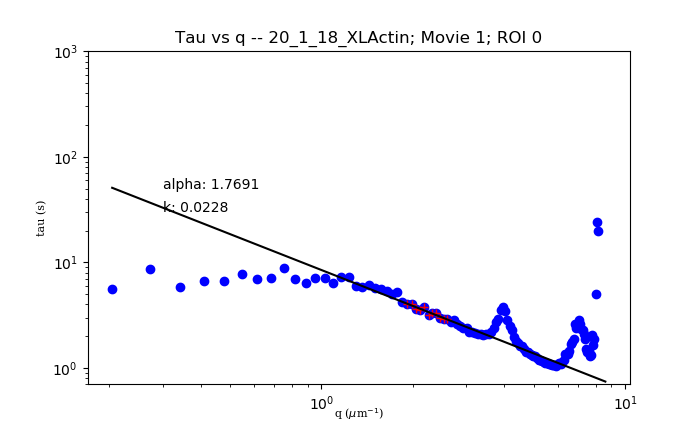

'slope' of tau vs q is -1.13


(0.7, 1000)

In [63]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(7,7/1.618)); ax = fig.gca();

plt.title("Tau vs q -- " + data_dir.split('\\')[-4] + "; Movie " + str(video) + "; ROI " + str(ROI))
qs=q[3:-1]
new_taus=ddm.newt(new_meth_taus[2:-1],stretch_exp[2:-1])
ax.loglog(qs, new_taus,'bo')

###########################################################################
# Pick the range of q-value that seem to fit best (usually ~25ish to ~42ish)
###########################################################################
minq=25
maxq=35

qmin=qs[minq]
qmax=qs[maxq]
b = np.where((qs>=qmin)&(qs<=qmax))
ax.plot(qs[b[0]],new_taus[b[0]],'r+')
a = np.polyfit(np.log(qs[b[0]]),np.log(new_taus[b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])
alpha = 2./(-1*slope)
Dif = (1.0/coef1)**alpha
tau_fit = coef1*(qs**(-2.0/alpha))
ax.plot(qs, tau_fit, '-k')
print("'slope' of tau vs q is %.2f" % slope)

ax.text(0.3,50, "alpha: %.4f" % alpha)
ax.text(0.3,30, "k: %.4f" % Dif)

ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.set_ylim(0.7,1000)

## Other method of getting $A$, $B$, $\tau$ and $\alpha$. 

You can go through this if you want. This is the previous method we used to fit our DDM data. 

In [139]:

backg = 9 #change me! <------------------------------------------

<IPython.core.display.Javascript object>


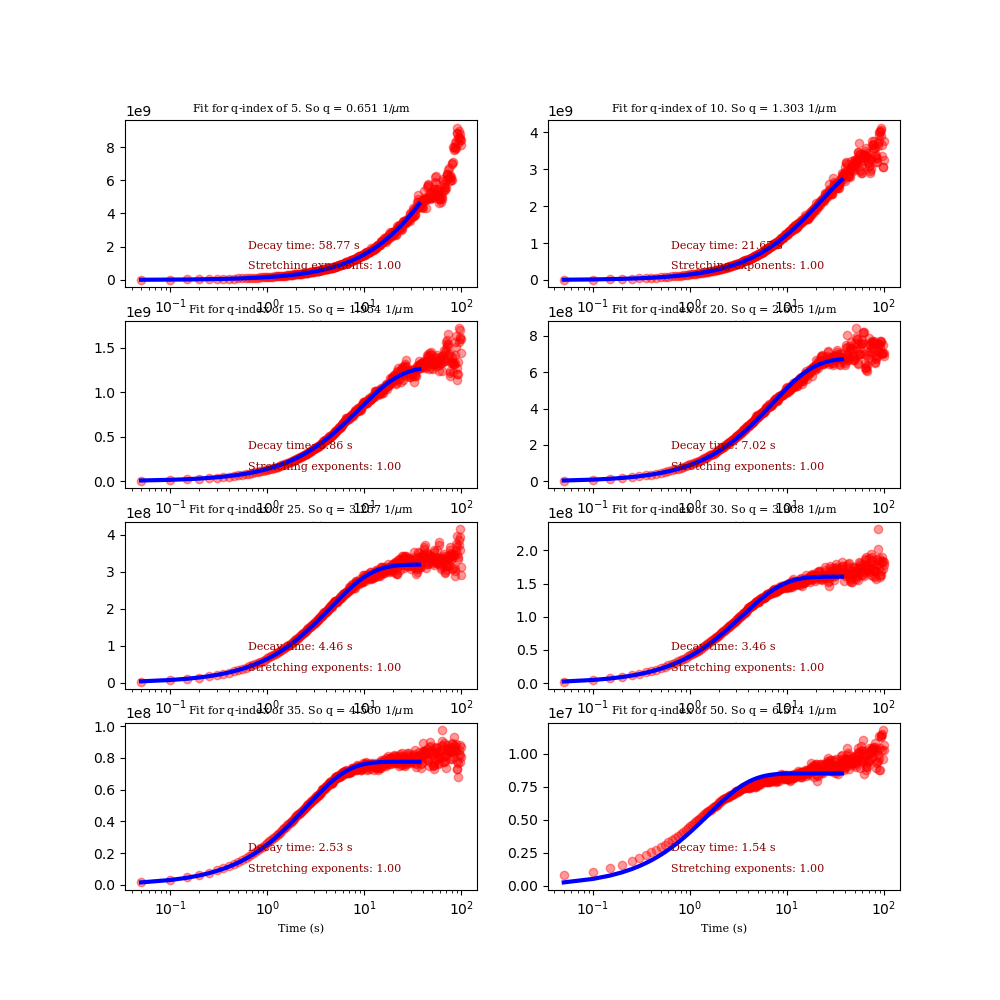

bg: 400.0
bg: 400.0
bg: 0.001
bg: 400.0
bg: 400.0
bg: 400.0
bg: 400.0
bg: 400.0


In [140]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''

    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=fps)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp) - 3, (... same for second exp..))
    
    #Decay time
    # The initial guess for this parameter will be generated automatically
    # But here we can set the minimum and maximum of the possible values. 
    maxp[1] = 1000    #The decay time can't be larger than this
    minp[1] = 0.001   #The decay time can't be smaller than this
    
    #Background
    maxp[2]=400
    minp[2]=0.001
    pars[2]=backg #This was set in the previous code block
    
    #Stretching exponent. Ideally, this should be 1.0 (which would be a normal exponential)
    minp[3]=0.15   #Can't be smaller than this
    maxp[3]=1.01  #Can't be larger than this
    pars[3]=1.0  #The initial guess. Usually, this should be 1 unless you suspect anomalous behavior. 
    
    #We can choose to allow certain paramters to vary or we can fix them.
    # In the 'fix' vector, if we set to True, the value will be fixed and not allowed to vary.
    fix[3]= True  #Determines whether we fix alpha (the stretching exponent) or not
    fix[2]= False   #Determines whether we fix the background or not.
    

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

%matplotlib notebook
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)

q_index = 10  # 10 usually works because it tends to fit well for all types of dynamics
end_time = 300  # change this if the data plateaus early, it is where the fitting stops
#Loop over four different q-values to do the fit
for i,q_index in enumerate([5,10,15,20,25,30,35,50]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:end_time,q_index], times[:end_time])
    #print len(theoryB)
    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times[:len(theoryB)], theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.125,'Stretching exponents: %.2f' % (fitparamsB[3]), 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)

    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    print ("bg:", fitparamsB[2])

In [141]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]

Y:\Pawan K\DDM\ddm_clean.py:243: RuntimeWarning: overflow encountered in exp
  g1 = np.exp(-1 * (x / t1)**s1)
Y:\Pawan K\DDM\ddm_clean.py:245: RuntimeWarning: overflow encountered in multiply
  d = a1 * (1 - g1) + a2 * (1 - g2) + bg


<IPython.core.display.Javascript object>


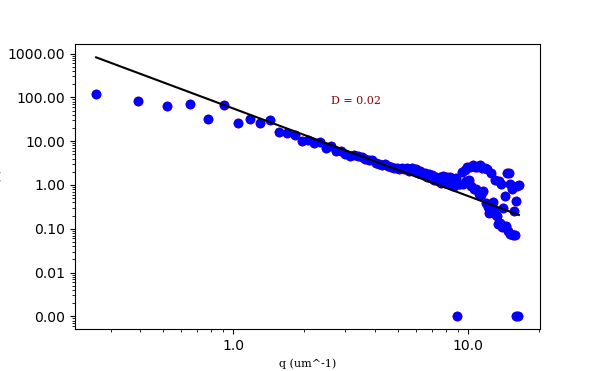

<IPython.core.display.Javascript object>


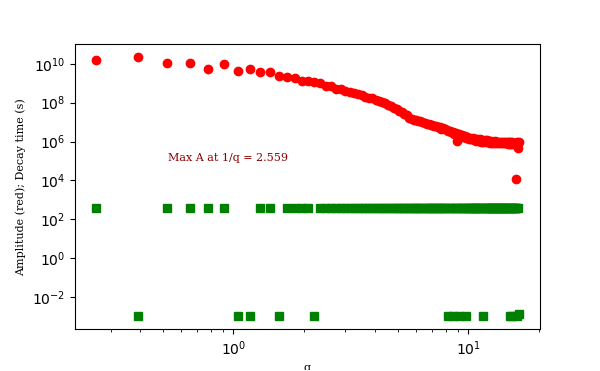

In [148]:
%matplotlib notebook

#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(6,6/1.618)); ax = fig.gca(); 
ax.loglog(q[2:-1], tau[2:-1], 'ro')
ax.loglog(q[2:-1], ddm.newt(tau[2:-1],alph[2:-1]),'bo')
diffusion_coeff = 0.0180
ax.plot(q[2:-1], (1./diffusion_coeff) * 1./(q[2:-1]**2), '-k')
ax.set_xlabel("q (um^-1)", fontdict=font_plt_ax)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.1f}'.format))
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
ax.text(0.55,0.8,'D = %.2f' % diffusion_coeff, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(6,6/1.618)); ax = fig.gca(); 
ax.loglog(q[2:-1], amp[2:-1], 'ro')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[2:-1][w]
ax.loglog(q[2:-1], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);